In [1]:
# to reproduce the figures in the paper
gnome_test_run = "20250113_00_07"

# to generate figures for newly measured data, comment out the two lines above and uncomment the following:
#gnome_test_run = "gnome_latest"

In [2]:
from pathlib import Path,PosixPath
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def load_times():
    p = Path(f"../measurements/{gnome_test_run}")
    fs = '*'
    use_case = 'gnome'
    all_cases = sorted(list(p.glob(f"{fs}_{use_case}")) + list(p.glob(f"{fs}_*_{use_case}")))
    
    for c in all_cases:
        runs = list(c.glob("*"))
        for run in runs:
            with open(run, "r") as f:
                j = json.loads(f.read())
                match = re.match(r'test_(\D+?)(\d+)', run.name)
                app = match.group(1)
                run_nr = int(match.group(2))
    
                if str(c.name).count("_") == 2:
                    fs, cipher, _ = tuple(str(c.name).split('_'))
                elif str(c.name).count("_") == 1:
                    fs, _ = tuple(str(c.name).split('_'))
                    cipher = 'none'
    
                for i in ((fs, cipher, app, run_nr, i, t) for (i, t) in enumerate(j["results"][0]["times"])):
                    yield i
    return

tuple_fields_name_list = ['fs', 'cipher', 'app', 'run', 'round', 'time']
df = pd.DataFrame.from_records(load_times(), columns=tuple_fields_name_list)
df['cipher'] = df['cipher'].str.replace('sphincs', 'S', regex=True)
df['cipher'] = df['cipher'].str.replace('simple', '', regex=True)
df['cipher'] = df['cipher'].str.replace('prime256v1', 'ecdsa-p256', regex=True)
df['cipher'] = df['cipher'].str.replace('rsa-4096', 'rsa4096', regex=True)
df['cipher'] = df['cipher'].str.replace('lms', '', regex=True)

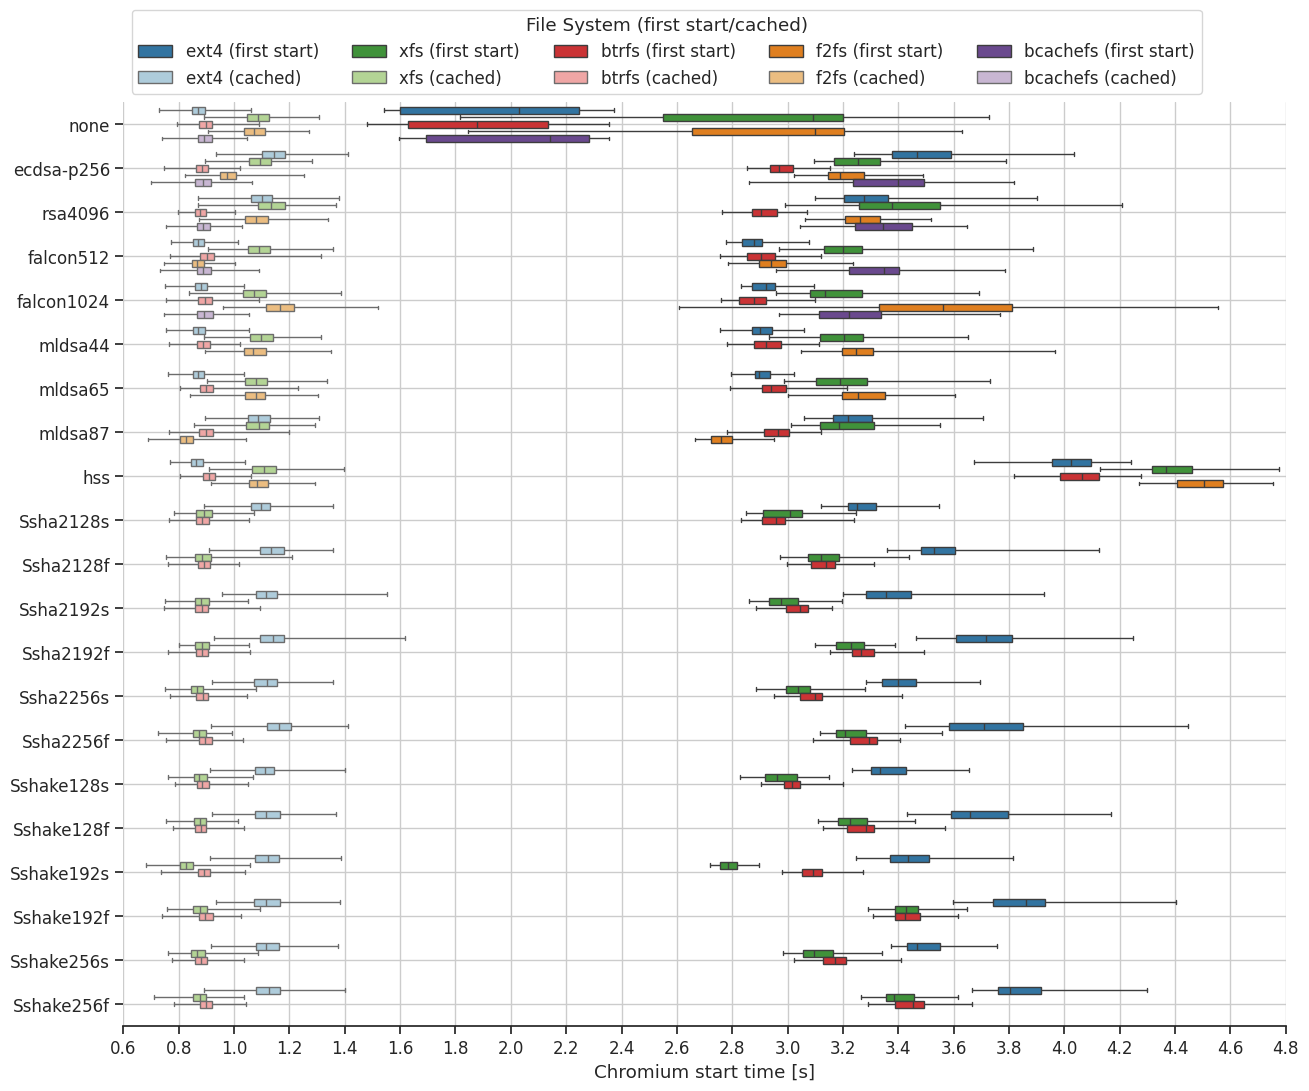

In [3]:
def plot_seaborn_combined(df, col):
    order = [
        'none',
        'ecdsa-p256',
        'rsa4096',
        'falcon512',
        'falcon1024',
        'mldsa44',
        'mldsa65',
        'mldsa87',
        'hss',
        'Ssha2128s', 
        'Ssha2128f', 
        'Ssha2192s', 
        'Ssha2192f', 
        'Ssha2256s', 
        'Ssha2256f',
        'Sshake128s',
        'Sshake128f', 
        'Sshake192s',
        'Sshake192f',
        'Sshake256s',
        'Sshake256f'
    ]

    fs_order = ['ext4', 'xfs', 'btrfs', 'f2fs', 'bcachefs']

    sns.set_theme(style="ticks", font_scale=1.1)
    f, ax = plt.subplots(figsize=(15, 12))
    sns.boxplot(df[df['round'] == 0], x=col, y="cipher", hue='fs', whis=[0, 100], width=.8, order=order, hue_order=fs_order, palette=sns.color_palette("Paired")[1::2][:5])
    sns.boxplot(df[df['round'] > 0], x=col, y="cipher", hue='fs', whis=[0, 100], width=.8, order=order, hue_order=fs_order, palette=sns.color_palette("Paired")[::2][:5])
    ax.set_xlim([0.6, 4.8])
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set(ylabel="")
    ax.set(xlabel="Chromium start time [s]")
    sns.despine(trim=False, left=True)


    handles, labels = plt.gca().get_legend_handles_labels()

    labels_first = [f"{l} (first start)" for l in labels[len(labels)//2:]] 
    labels_cached = [f"{l} (cached)" for l in labels[:len(labels)//2]]
    labels = labels_first + labels_cached
    labels[::2] = labels_first
    labels[1::2] = labels_cached

    handles_first = handles[len(handles)//2:]
    handles_cached = handles[:len(handles)//2]
    handles[::2] = handles_cached
    handles[1::2] = handles_first

    ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.0, 1.0), ncols=5, title='File System (first start/cached)')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

    return f

f = plot_seaborn_combined(df[(df['run'] >= 6)], 'time') # run >= 6 removes first 5 warmup runs
f.savefig("app_start.pdf", format="pdf", bbox_inches="tight")